# Forecasting Bike Hire Trips

The workflow of this project: Initaly loads ride data from a set of CSV files from 2014-2017, creates a Cartesian product of dates, start station, and end station, filters for the most connected station pairs, and groups the data by station pair and date to compute the number of rides and median ride duration per day. Then I select a specific station pair and fits a Prophet model to forecast the number of rides for the next seven days. The model is then cross-validated using a rolling window approach with a horizon of seven days and a period of five days. Performance metrics including RMSE and MSE are then computed based on the cross-validation results. Finally, for visualization the forecast is plotted. The approach I used in this project is basically a standard workflow for time series forecasting using the Prophet library, including data preparation, model fitting, and evaluation.

# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta
import glob
import prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
%matplotlib inline

# Generating Dataframe of OD csv's

In [4]:
generator_rides = (pd.read_csv(f) for f in glob.iglob('csv/OD_*.csv', recursive=True))
rides = pd.concat(generator_rides, ignore_index=True)

rides['start_date'] = pd.to_datetime(rides['start_date'])
rides['end_date'] = pd.to_datetime(rides['end_date'])

# print(rides.head())

# limiting up to the 10th of September
rides = rides.loc[rides['end_date'] < pd.to_datetime('2017-09-11')]

# print(rides.head())

In [5]:
rides.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2014-04-15 00:01:00,6209,2014-04-15 00:18:00,6436,1061,1
1,2014-04-15 00:01:00,6214,2014-04-15 00:11:00,6248,615,1
2,2014-04-15 00:01:00,6164,2014-04-15 00:18:00,6216,1031,1
3,2014-04-15 00:01:00,6214,2014-04-15 00:24:00,6082,1382,1
4,2014-04-15 00:02:00,6149,2014-04-15 00:08:00,6265,347,1


# PreProcessing

#### Below cell explained
- It defines a start and end date for the time period of interest.
- It generates a list of all dates within the time period of interest using the datetime module and creates a dataframe with a single column 'date' containing all dates.
- It calculates the importance of each link (start station to end station) in the dataset by grouping the data by start and end station and counting the number of rides taken between them.
- It keeps only the most connected pairs of bike stations by selecting those links where the count of rides is greater than or equal to 700. This value is hardcoded, but it could be modified to a different threshold if needed.
- It merges the dataframe containing all dates with the dataframe containing the most connected pairs of bike stations. This generates a new dataframe containing all dates for each pair of bike stations.
- It groups the original rides dataframe by start station, end station, and date, to get the number of bike rides taken per day for each link.
- It merges the resulting dataframe with the one generated in step 5 to obtain the number of rides per day for each pair of bike stations and each day within the time period of interest. If there were no rides on a specific day for a given pair of stations, the value in the 'rides_perday' column is set to 0.
- Finally, it returns the resulting dataframe with information about the number of bike rides taken between the most connected pairs of bike stations per day, over a specific time period.

In [26]:
# approach: cartesian product of dates, start station and end station

# let us generate all dates
d1 = date(2014,4,15)
d2 = date(2017,9,10)

all_dates = pd.DataFrame({'date':pd.to_datetime([d1 + timedelta(days=x) for x in range((d2-d1).days + 1)])})

# keep only most connected pairs
link_importance = rides.groupby(['start_station_code', 'end_station_code'])[['duration_sec']].count()
link_importance.rename(columns={'duration_sec':'rides_perlink_count'}, inplace=True)
link_importance_top1pc = link_importance.loc[link_importance['rides_perlink_count']>=700]
link_importance_top1pc.reset_index(inplace=True)

all_dates['key'] = 0
link_importance_top1pc['key'] = 0

rides_completedates = all_dates.merge(link_importance_top1pc, how='left', on='key')

rides_completedates.drop('key',1, inplace=True)
all_dates.drop('key',1,inplace=True)

rides['start_date_daytrunc'] = rides['start_date'].dt.floor('d')

rides_perday_activeonly = rides.groupby(['start_station_code', 'end_station_code', 'start_date_daytrunc']).agg(
    rides_perday=('duration_sec', 'count'), 
    median_duration_sec_perday=('duration_sec', 'median')
).reset_index()
rides_perday = rides_completedates.merge(rides_perday_activeonly, left_on = ['start_station_code', 'end_station_code', 'date'] ,
                                         right_on = ['start_station_code', 'end_station_code', 'start_date_daytrunc'], how='left')

rides_perday['rides_perday'].fillna(value=0, inplace=True)
rides_perday.head()

<ipython-input-26-05e5085c3b81>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,start_station_code,end_station_code,rides_perlink_count,start_date_daytrunc,rides_perday,median_duration_sec_perday
0,2014-04-15,5002,5007,782,NaT,0.0,NaN
1,2014-04-15,5004,5007,831,NaT,0.0,NaN
2,2014-04-15,5005,5007,995,NaT,0.0,NaN
3,2014-04-15,5006,5007,874,NaT,0.0,NaN
4,2014-04-15,5007,5002,734,NaT,0.0,NaN


# From station 6184 to station 6015

In [28]:
rides_6184_to_6015 = rides_perday.loc[(rides_perday['start_station_code']==6184) & (rides_perday['end_station_code']==6015)]
rides_6184_to_6015.head()

,date,start_station_code,end_station_code,rides_perlink_count,start_date_daytrunc,rides_perday,median_duration_sec_perday
1154,2014-04-15,6184,6015,2051,2014-04-15,1.0,517.0
3427,2014-04-16,6184,6015,2051,2014-04-16,3.0,580.0
5700,2014-04-17,6184,6015,2051,2014-04-17,3.0,412.0
7973,2014-04-18,6184,6015,2051,2014-04-18,2.0,1642.0
10246,2014-04-19,6184,6015,2051,2014-04-19,1.0,461.0


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='median_duration_sec_perday', ylabel='Density'>

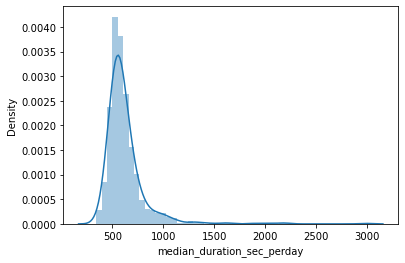

In [29]:
sns.distplot(rides_6184_to_6015.dropna()['median_duration_sec_perday'])

# Prediction using FB's Prophet on stations 6184 to 6015

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


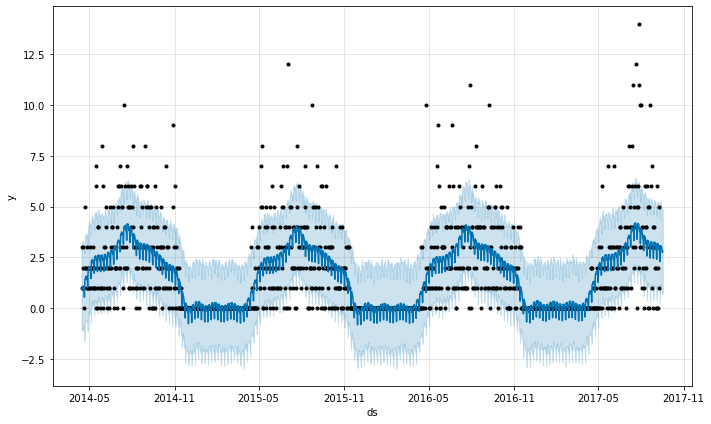

In [30]:
rides_6184_to_6015_prophet = pd.DataFrame({'ds':rides_6184_to_6015['date'].values, 
                                            'y':rides_6184_to_6015['rides_perday'].values})
m = prophet.Prophet()
m.fit(rides_6184_to_6015_prophet)
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)
fig1 = m.plot(forecast)

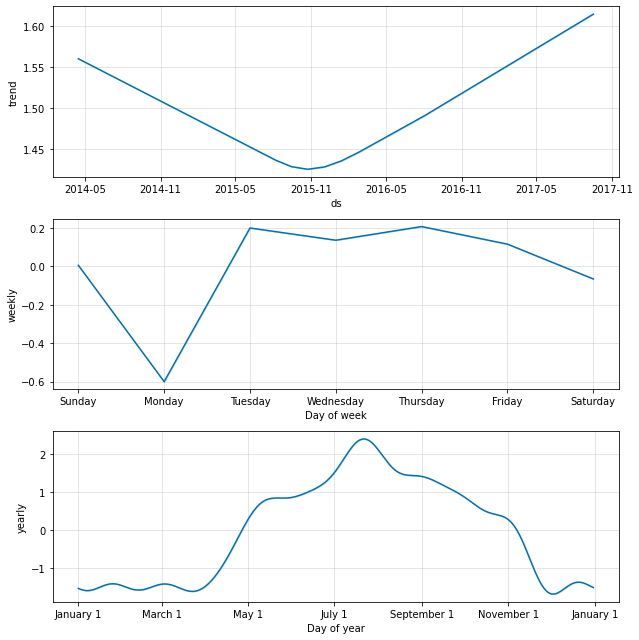

In [31]:
fig2 = m.plot_components(forecast)

#### Performing cross validation on a fitted model using cross_validation function provided by the Prophet library.
- initial: The size of the initial training period, which is specified as a string that represents the number of days of historical data to be used to train the model initially. In this case, it is set to '900 days'.
- horizon: The forecast horizon for each evaluation period, which is also specified as a string that represents the number of days. In this case, it is set to '7 days', meaning that the model is trained on 900 days of historical data and then evaluated on 7-day periods.
- period: The spacing between evaluation periods, also specified as a string representing the number of days. In this case, it is set to '5 days', meaning that the model is trained every 5 days after the initial training period.

The output of cross_validation is a Pandas dataframe df_cv containing the predictions and actual values for each evaluation period.

#### After cross-validation, the performance_metrics function is called to calculate performance metrics for the model on each evaluation period.
- df_cv: The cross-validation output dataframe
- rolling_window: The size of the rolling window for the performance metrics calculation. In this case, it is set to 1, meaning that the metrics are calculated for each evaluation period separately.
- metrics: A list of metrics to be calculated. In this case, the metrics are set to 'rmse' (root mean squared error) and 'mse' (mean squared error).

The output of performance_metrics is a Pandas dataframe df_p containing the performance metrics for the model on each evaluation period.

In [32]:
df_cv = cross_validation(m, initial='900 days', horizon = '7 days', period='5 days')
df_p = performance_metrics(df_cv, rolling_window=1, metrics=['rmse', 'mse'])
df_p

INFO:prophet:Making 68 forecasts with cutoffs between 2016-10-03 00:00:00 and 2017-09-03 00:00:00
  0%|          | 0/68 [00:00<?, ?it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
  1%|▏         | 1/68 [00:00<00:18,  3.72it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
  3%|▎         | 2/68 [00:00<00:17,  3.79it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
  4%|▍         | 3/68 [00:00<00:16,  3.92it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
  6%|▌         | 4/68 [00:01<00:15,  4.07it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
  7%|▋         | 5/68 [00:01<00:15,  4.01it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
  9%|▉         | 6/68 [00:01<00:15,  4.03it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 10%|█         | 7/68 [00:01<00:15,  4.01it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 12%|█▏        | 8/68 [00:02<00:15,  3.96it/s]INFO:cmdstanpy:start cha

,horizon,rmse,mse
0,7 days,1.779508,3.166648


# Forecast from September 4th 00:00:00 to September 10th 23:59:59

In [44]:
requested_forecast = forecast[forecast['ds'].between(pd.to_datetime('2017-09-04'), pd.to_datetime('2017-09-10'))].set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]
requested_forecast

,yhat,yhat_lower,yhat_upper
ds,,,
2017-04-15,0.702774,-1.368846,2.864145
2017-04-16,0.838065,-1.281983,3.032946
2017-04-17,0.296956,-1.763772,2.523528
2017-04-18,1.164910,-0.823686,3.273392
2017-04-19,1.169532,-1.013012,3.182382
...,...,...,...
2017-09-06,3.113093,1.031037,5.125894
2017-09-07,3.169699,1.102251,5.244032
2017-09-08,3.062424,0.997656,5.169108


In [34]:
import plotly.graph_objs as go

combined_6184_to_6015 = pd.merge(rides_6184_to_6015_prophet, forecast, on='ds')

fig = go.Figure()
fig.add_trace(go.Scatter(x=combined_6184_to_6015['ds'], y=combined_6184_to_6015['y'],
                    mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=combined_6184_to_6015['ds'], y=combined_6184_to_6015['yhat'],
                    mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=combined_6184_to_6015['ds'], y=combined_6184_to_6015['yhat_upper'],
                    fill='tonexty', mode='lines', name='Upper Bound'))
fig.add_trace(go.Scatter(x=combined_6184_to_6015['ds'], y=combined_6184_to_6015['yhat_lower'],
                    fill='tonexty', mode='lines', name='Lower Bound'))

fig.update_layout(title='Comparison between Historical Data and Forecast',
                   xaxis_title='ds',
                   yaxis_title='y')

fig.show()


In [35]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)